# DQ3 Earthquakes: Analytical Study on the Data Scraped from Wikipedia
### Xtreme United
#### Justine Rothbart, Massih Forootan,  Claude Stagg and Shruti Sharma

### Data Question 
A small committee at the USGS offices has approached your team to explore the deadly earthquakes data, hoping you can use data science methods to answer some questions about earthquakes (why, where, how, when do earthquakes occur). Please advise the committee on **data cleanup efforts**, articulate & **visualize your findings**, and make any **recommendations** you have to anticipate and/or reduce the impact of these disastrous events.
### Data Source
![DataSource](Screen Shot 2017-12-16 at 9.33.35 AM.png)

### Importing Relevant Libraries

In [105]:
import urllib.request
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import re
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline
import json
import requests
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from IPython.display import Image
from IPython.display import display, clear_output
from IPython.display import IFrame 
from IPython.core.display import HTML 
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Collecting and Parsing Html into DataFrame

In [15]:
request = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result = urllib.request.urlopen(request)
resulttext = result.read()
soup = BS(resulttext,'html.parser')
print(soup.title.string)

List of deadly earthquakes since 1900 - Wikipedia


In [36]:
eq_table=soup.find('table', class_='sortable wikitable')
print(eq_table)

<table class="sortable wikitable">
<tr bgcolor="#CCCCCC">
<th width="22%">Origin (<a class="mw-redirect" href="/wiki/UTC" title="UTC">UTC</a>)</th>
<th width="33%">Present-day country and link to Wikipedia article</th>
<th width="10%"><a href="/wiki/Latitude" title="Latitude">Lat</a></th>
<th width="10%"><a href="/wiki/Longitude" title="Longitude">Long</a></th>
<th width="8%">Depth (<a class="mw-redirect" href="/wiki/Km" title="Km">km</a>)</th>
<th width="6%">Magnitude</th>
<th width="9%">Secondary Effects</th>
<th width="10%">PDE Shaking Deaths</th>
<th width="10%">PDE Total Deaths</th>
<th width="10%">Utsu Total Deaths</th>
<th width="10%">EM-DAT Total Deaths</th>
<th width="12%">Other Source Deaths</th>
</tr>
<tr>
<td>1900-05-11 17:23</td>
<td>Japan</td>
<td>38.700</td>
<td>141.100</td>
<td>5</td>
<td>7.0 <a class="mw-redirect" href="/wiki/Seismic_scale#Mjma" title="Seismic scale"><span title="JMA mag.">M<sub>JMA</sub></span></a></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td

### Preparing the Data Frame from Html

In [49]:
#Body
data = []
for row in eq_table.find_all('tr'):
    cells = row.find_all('td')
    cells = [ele.text.strip() for ele in cells]
    data.append(cells)
    eq_df = pd.DataFrame(data)
    eq_df = eq_df.drop(0,0)
eq_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
1,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,
2,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,
3,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,
4,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,
5,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,


In [50]:
#Headers
headers = [cell.get_text() for cell in eq_table.find_all('th')]
print(headers)
eq_df.columns = headers
columns = ['origin','country','lat','lng','depth_km','magnitude','sec_effects','shaking_deaths','pde_total','utsu_total','em_total','other_deaths']


['Origin (UTC)', 'Present-day country and link to Wikipedia article', 'Lat', 'Long', 'Depth (km)', 'Magnitude', 'Secondary Effects', 'PDE Shaking Deaths', 'PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']


### Earthquake Data Frame 

In [51]:
eq_df.columns = columns
eq_df.head()

,origin,country,lat,lng,depth_km,magnitude,sec_effects,shaking_deaths,pde_total,utsu_total,em_total,other_deaths
1,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,
2,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,
3,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,
4,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,
5,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,


### Clean Up of the Data to Remove Links, Subscripts, annotations, Special Characters

In [52]:
eq_df['magnitude'] = eq_df['magnitude'].str.replace('([a-zA-Z])','')
eq_df['magnitude'] = eq_df['magnitude'].str.replace('\[..\]','')
eq_df['other_deaths'] = eq_df['other_deaths'].str.replace('\[..\]','')
eq_df['country'] = eq_df['country'].str.replace('\([^\)]*\)*', '')
eq_df['country'] = eq_df['country'].str.strip()
eq_df['other_deaths'] = eq_df['other_deaths'].str.replace('\([^\)]*\)*', '')
eq_df['other_deaths'] = eq_df['other_deaths'].str.replace('\+', '')
eq_df['em_total'] = eq_df['other_deaths'].str.replace('\[7\]\|', '')

### Converting the Columns to Appropriate DataType for Comparative Analysis and Visualization

In [53]:
eq_df['pde_total'] = pd.to_numeric(eq_df['pde_total'], errors='coerce')
eq_df['utsu_total'] = pd.to_numeric(eq_df['utsu_total'], errors='coerce')
eq_df['em_total'] = pd.to_numeric(eq_df['em_total'], errors='coerce')
eq_df['other_deaths'] = pd.to_numeric(eq_df['other_deaths'], errors='coerce')
print(eq_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340 entries, 1 to 1340
Data columns (total 12 columns):
origin            1340 non-null object
country           1340 non-null object
lat               1340 non-null object
lng               1340 non-null object
depth_km          1340 non-null object
magnitude         1340 non-null object
sec_effects       1340 non-null object
shaking_deaths    1340 non-null object
pde_total         750 non-null float64
utsu_total        1027 non-null float64
em_total          28 non-null float64
other_deaths      28 non-null float64
dtypes: float64(4), object(8)
memory usage: 136.1+ KB
None


### Creating a New Column to record the Max Casualties Reported Between Different Sources

In [78]:
eq_df['deaths'] = eq_df[['pde_total','utsu_total','em_total','other_deaths']].max(axis=1)
eq_df.tail()

,origin,country,lat,lng,depth_km,magnitude,sec_effects,shaking_deaths,pde_total,utsu_total,em_total,other_deaths,deaths
1336,2011-03-11 14:46,Japan,38.322,142.369,24.4,9.0,T,,NaN,NaN,15894.0,15894.0,15894.0
1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1338,2011-04-07 14:32,Japan,38.2,140.0,66.0,7.1,,,NaN,NaN,NaN,NaN,NaN
1339,2011-09-18 12:40,India,27.723,88.064,19.7,6.9,L,,NaN,NaN,111.0,111.0,111.0
1340,2011-09-23 10:41,Turkey,38.6,43.5,7.2,7.1,,,NaN,NaN,601.0,601.0,601.0


In [101]:
eq_df.loc[eq_df.lat ==''] = np.nan
eq_df.loc[eq_df.lng ==''] = np.nan

eq1= eq_df.dropna(subset=['lat','lng','deaths'])
eq1.lat = pd.to_numeric(eq1.lat, errors='coerce')
eq1.lng = pd.to_numeric(eq1.lng, errors='coerce')
eq1.deaths = pd.to_numeric(eq1.deaths, errors='coerce')
eq1.depth_km = pd.to_numeric(eq1.depth_km, errors='coerce')
eq1.magnitude = pd.to_numeric(eq1.magnitude, errors='coerce')
eq1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1237 entries, 2 to 1340
Data columns (total 13 columns):
origin            1237 non-null object
country           1237 non-null object
lat               1236 non-null float64
lng               1236 non-null float64
depth_km          1161 non-null float64
magnitude         1237 non-null float64
sec_effects       1237 non-null object
shaking_deaths    1237 non-null object
pde_total         750 non-null float64
utsu_total        1027 non-null float64
em_total          20 non-null float64
other_deaths      20 non-null float64
deaths            1237 non-null float64
dtypes: float64(9), object(4)
memory usage: 135.3+ KB


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Visializing Earthquake Data on the Map Using Geopandas and Matplotlib


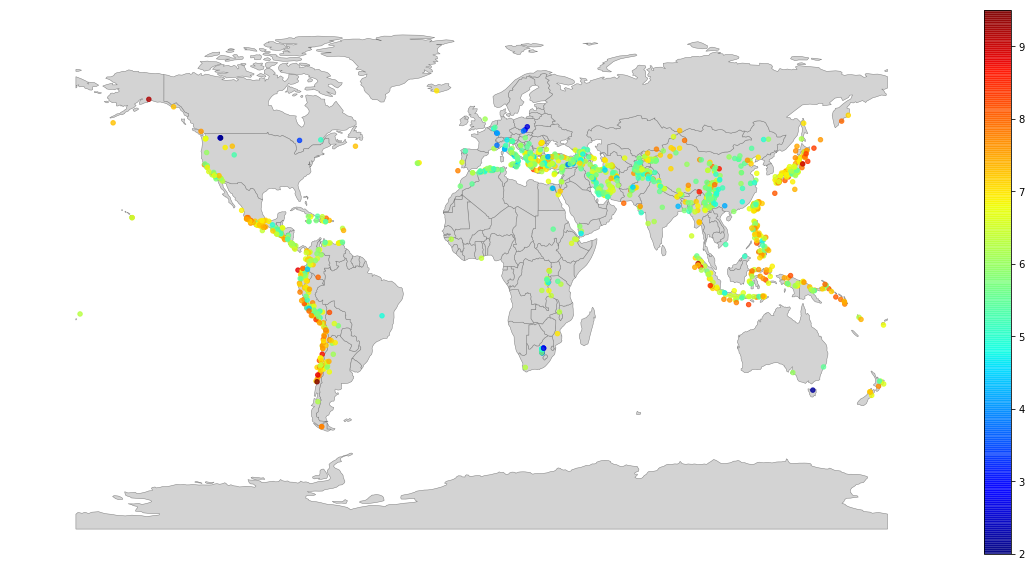

In [102]:
fig, ax = plt.subplots(figsize = (20,10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax = ax,linewidth=0.5, edgecolor='gray', color='lightgray')
ax.axis('off')
eq_sc = plt.scatter(x=eq1["lng"], y=eq1["lat"],s=20, label=eq1['magnitude'],
    c=list(eq1['magnitude']), cmap=plt.get_cmap("jet"),alpha=0.8)
plt.colorbar(eq_sc)
plt.show()

### Interactive Widgets with Map

In [108]:
geometry = [Point(xy) for xy in zip(eq1.lng, eq1.lat)]
crs = {'init': 'epsg:4326'}
eq1 = GeoDataFrame(eq1, crs=crs, geometry=geometry)
eq1
def country_drop(x):
    clear_output(wait=True)
    pylab.rcParams['figure.figsize'] = 20, 20
    country = world.loc[world.name == x]
    base = country.plot(color='lightgray', edgecolor='gray')
    fig = base.get_figure()
    base.axis('off')
    for row in eq1:
        eq_bool = (x == eq1['country'])
        eq_table = eq1[eq_bool==True]
        eq_table.plot(ax=base, marker='o', alpha = 0.6, column = 'magnitude', cmap = 'jet', markersize = 40)
        space = make_axes_locatable(base)
        loc = space.append_axes('right', size='3%', pad=0.01)
        sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=1.0, vmax=10.0))
        sm._A = []
        fig.colorbar(sm,cax=loc);
    return plt.show()

eq_country = widgets.Dropdown(
    options=[
        'China',
        'Japan',
        'Pakistan',
        'Peru',
        'Turkey',],
    description='Country:',
    disabled=False,
    readout=True,
)

widgets.interact(country_drop, x= eq_country);

interactive(children=(Dropdown(description='Country:', options=('China', 'Japan', 'Pakistan', 'Peru', 'Turkey'), value='China'), Output()), _dom_classes=('widget-interact',))

### Earthquakes : Casualties as Scatter with Magnitude

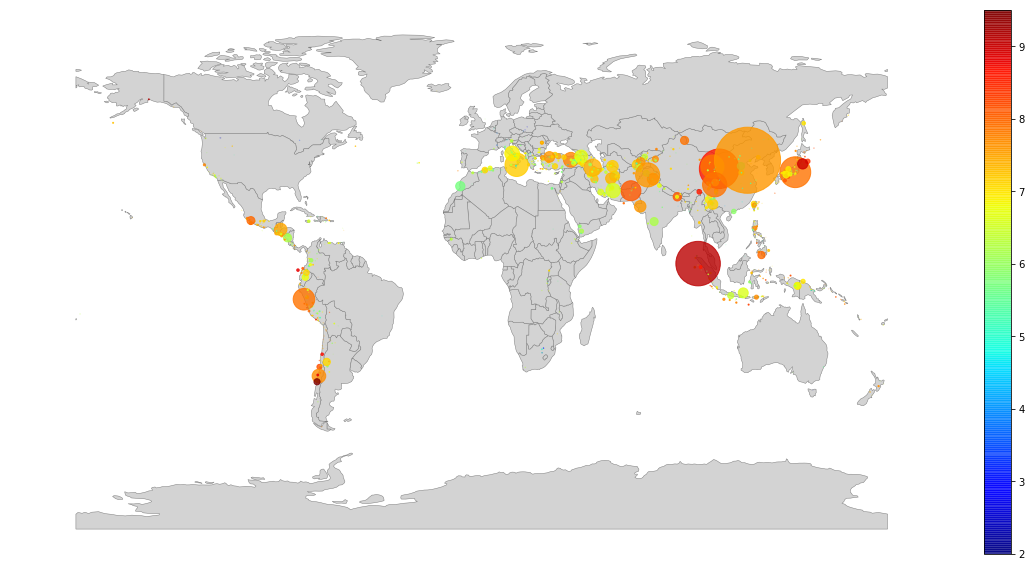

In [109]:
fig, ax = plt.subplots(figsize = (20,10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax = ax,linewidth=0.5, edgecolor='gray', color='lightgray')
ax.axis('off')
eq_sc = plt.scatter(x=eq1["lng"], y=eq1["lat"],s=eq1['deaths']/150, label=eq1['country'],
    c=list(eq1['magnitude']), cmap=plt.get_cmap("jet"),#tab20b
     alpha=0.8)
plt.colorbar(eq_sc)
plt.show()

### Earthquakes: Depth as Scatter with Magnitude

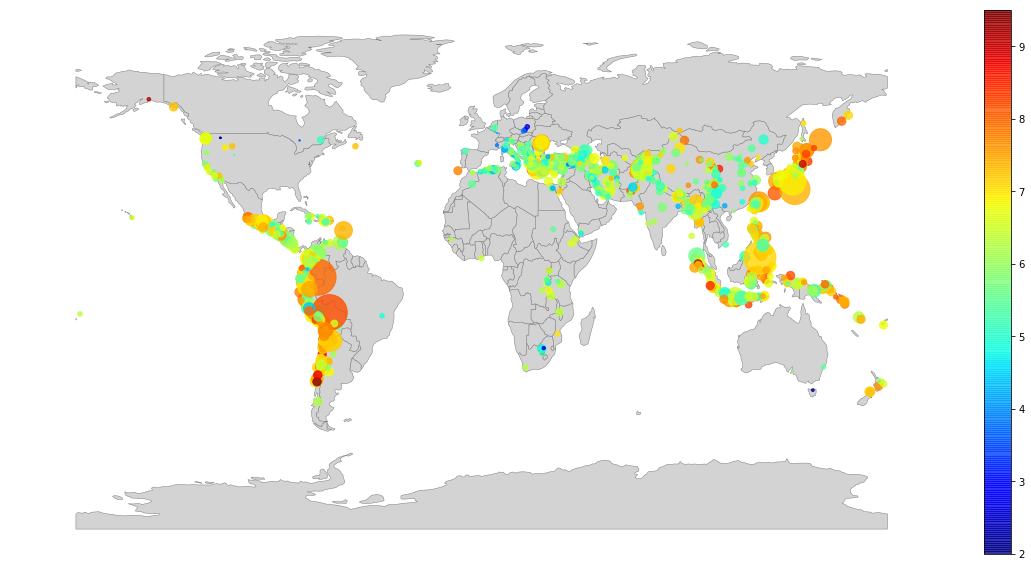

In [139]:
fig, ax = plt.subplots(figsize = (20,10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax = ax,linewidth=0.5, edgecolor='gray', color='lightgray')
ax.axis('off')
eq_sc = plt.scatter(x=eq1["lng"], y=eq1["lat"],s=eq1['depth_km']*2, label=eq1['country'],
    c=list(eq1['magnitude']), cmap=plt.get_cmap("jet"),alpha=0.8)
plt.colorbar(eq_sc)
plt.show()

In [111]:
seasonum={
    0:"winter",
    1:"spring",
    2:"summer",
    3:"authumn"
}

In [116]:

# eq_sd=eq_df.drop(['depth_km', 'sec_effects', 'pde_total', 'utsu_total', 'em_total', 'other_deaths'],1)


,origin,country,lat,lng,magnitude,shaking_deaths,deaths
1,1900-05-11 17:23,Japan,38.700,141.100,7.0,,NaN
2,1900-07-12 06:25,Turkey,40.300,43.100,5.9,,140.0
3,1900-10-29 09:11,Venezuela,11.000,-66.000,7.7,,NaN
4,1901-02-15 00:00,China,26.000,100.100,6.5,,NaN
5,1901-03-31 07:11,Bulgaria,43.400,28.700,6.4,,4.0


In [129]:
eq_mas = pd.read_csv('eq_sd_csv.csv')
eq_mas.head()

,Unnamed: 0,origin,country,lat,long,magnitude,shaking_death,deaths,year,month,decade,hour,Season,sleep,Class,year5
0,1,1900-05-11 17:23,Japan,38.7,141.1,7.0,NaN,NaN,1900,5,1900,2.0,spring,True,Major,1900
1,2,1900-07-12 06:25,Turkey,40.3,43.1,5.9,NaN,140.0,1900,7,1900,8.0,summer,False,Moderate,1900
2,3,1900-10-29 09:11,Venezuela,11.0,-66.0,7.7,NaN,NaN,1900,10,1900,4.0,authumn,True,Major,1900
3,4,1901-02-15 00:00,China,26.0,100.1,6.5,NaN,NaN,1901,2,1900,6.0,winter,True,Strong,1900
4,5,1901-03-31 07:11,Bulgaria,43.4,28.7,6.4,NaN,4.0,1901,3,1900,8.0,spring,False,Strong,1900


In [218]:
display(HTML("<h2> Ring of Fire </h2>"))


display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
Image(url= "Screen Shot 2017-12-13 at 10.02.21 AM.png",width=600 ,height=600)

In [132]:
# a subset where unknown deaths are removed
eq_sd_D = eq_mas.query('deaths != "NaN"')

In [133]:
# a subset where unknown shaking deaths are removed
eq_sd_n0 = eq_mas.query('shaking_death != "NaN"')

In [134]:
eq_g_sp=eq_sd_D.groupby(by=['sleep','Class'],as_index=False).mean()
eq_sp_pvt=eq_g_sp.pivot(index='sleep',columns='Class',values='deaths').fillna(0)
eq_spdth=eq_sp_pvt.reindex_axis(['Minor','Light','Moderate','Strong','Great'],axis=1)
eq_spdth

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Class,Minor,Light,Moderate,Strong,Great
sleep,,,,,
False,2.916667,7.333333,91.564593,393.579137,10749.000000
True,4.000000,3.681818,182.694030,813.119048,19211.571429


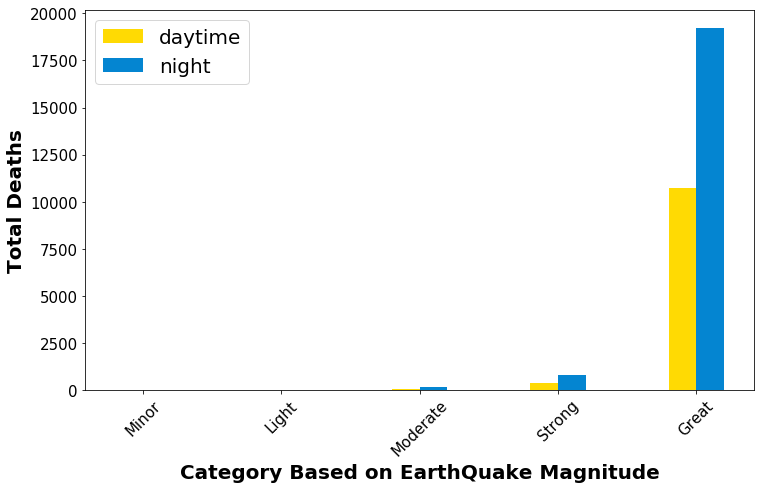

In [208]:
fig, ax = plt.subplots(figsize = (12,7))
x=np.arange(0,eq_spdth.shape[1])
y0=np.array(eq_spdth.iloc[0,:])
y1=np.array(eq_spdth.iloc[1,:])

b0=ax.bar(x-0.1,y0,0.2,color='#ffda03',label='daytime') 
b1=ax.bar(x+0.1,y1,0.2,color='#0485d1',label='night') #spring

plt.xticks(x,['Minor','Light','Moderate','Strong','Great'], rotation=45,fontsize=15, fontweight='normal')
plt.yticks(fontsize=15, fontweight='normal')
plt.xlabel('Category Based on EarthQuake Magnitude', fontsize=20, fontweight='bold')
plt.ylabel('Total Deaths', fontsize=20, fontweight='bold')
plt.legend(prop={'size': 20})
plt.show()


In [137]:
# Pivot average death over season and strength/mag
eq_g_sn = eq_sd_D.groupby(by=['Season','Class'],as_index=False).mean()
eq_sn_pvt=eq_g_sn.pivot(index='Season',columns='Class',values='deaths').fillna(0)
eq_sndth=eq_sn_pvt.reindex_axis(['Minor','Light','Moderate','Strong','Great'],axis=1)
eq_sndth2=eq_sndth.reindex_axis(['spring','summer','authumn','winter','unknown'],axis=0)

eq_sndth2=eq_sndth2.drop('unknown',0)
eq_sndth2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """


Class,Minor,Light,Moderate,Strong,Great
Season,,,,,
spring,3.250000,12.105263,180.216867,268.641379,5837.071429
summer,3.750000,3.500000,75.724490,287.495652,1521.500000
authumn,1.666667,3.000000,19.868132,549.546296,2455.375000
winter,3.500000,3.066667,277.442857,1289.428571,35574.625000


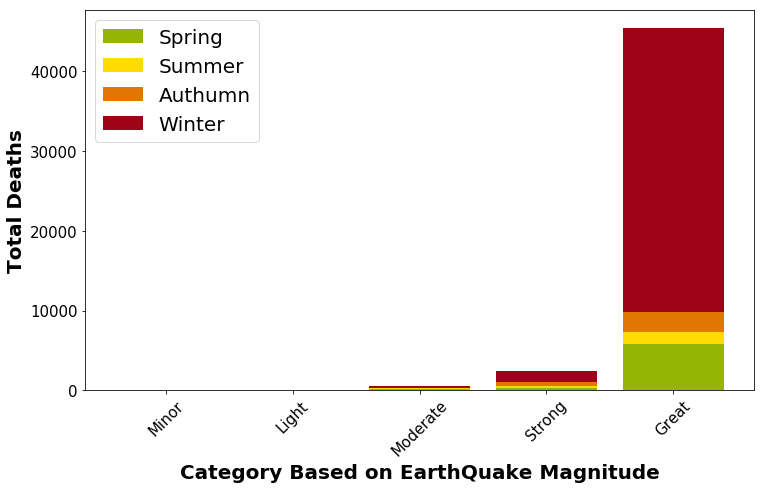

In [207]:
fig, ax = plt.subplots(figsize = (12,7))
x=np.arange(0,eq_sndth.shape[1])

y0=np.array(eq_sndth.loc['spring',:])
y1=np.array(eq_sndth.loc['summer',:])
y2=np.array(eq_sndth.loc['authumn',:])
y3=np.array(eq_sndth.loc['winter',:])

b3=plt.bar(x,y0,color='#96b403',label='Spring') 
b2=plt.bar(x,y1,bottom=y0,color='#ffda03',label='Summer')
b1=plt.bar(x,y2,bottom=y0+y1,color='#e17701',label='Authumn')
b0=plt.bar(x,y3,bottom=y0+y1+y2,color='#9d0216',label='Winter')

plt.xticks(x,['Minor','Light','Moderate','Strong','Great'], rotation=45,fontsize=15, fontweight='normal')
plt.yticks(fontsize=15, fontweight='normal')
plt.xlabel('Category Based on EarthQuake Magnitude', fontsize=20, fontweight='bold')
plt.ylabel('Total Deaths', fontsize=20, fontweight='bold')
plt.legend(prop={'size': 20})
plt.show()

In [216]:
display(HTML("<h2>Alpide Belt</h2>"))
Image(url= "Alpiner_Gebirgsgürtel.png",width=600 ,height=600)

In [142]:
display(IFrame('gmap_plot_EQ_Japan.html', width=700 ,height=500))